## 1. Loading data with new column names

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:

# 데이터 로드 및 df 생성
# data load and create dataframe with new column names

names = ['parcelid', 'air_conditioning_type', 'architectural_style', 
         'area_basement', 'num_bathroom', 'num_bedroom', 'framing_type',
         'building_quality', 'num_bathroom_calc', 'deck_type',
         'area_firstfloor_finished', 'area_total_calc',
         'area_living_finished', 'perimeter_living',
         'area_total', 'area_firstfloor_unfinished',
         'area_base', 'fips', 'num_fireplace', 'num_fullbath',
         'num_garagecar', 'area_garage', 'hashottuborspa',
         'heating_type', 'latitude', 'longitude',
         'area_lot', 'num_pool', 'area_pools', 'pooltypeid10',
         'pooltypeid2', 'pooltypeid7', 'property_land_use_code',
         'property_land_use_type', 'property_zoning_desc',
         'census_raw_tract_block', 'region_city', 'region_county',
         'region_neighborhood', 'region_zipcode', 'num_room', 'story_type',
         'num_34_bath', 'material_type', 'num_unit',
         'area_patio', 'area_shed', 'build_year',
         'num_stories', 'flag_fireplace', 'tax_assessed_structure_value',
         'tax_assessed_parcel_value', 'tax_assessment_year', 'tax_assessed_land_value',
         'tax_property', 'tax_delinquency_flag', 'tax_delinquency_year',
         'census_tract_block']

train_df   = pd.read_csv('../input/zillow-prize-1/train_2016_v2.csv', parse_dates=["transactiondate"]);
prop_df    = pd.read_csv('../input/zillow-prize-1/properties_2016.csv', names=names, header=0);
sample_df  = pd.read_csv('../input/zillow-prize-1/sample_submission.csv')

## 2. Check type and nan data

#### In addition, for the next step after a simple EDA of data sets(part 3.) with some graphs, we will fill missing values in various ways. So in this part 2, We will explain some columns with null values and choose columns to fill missing values just briefly.


In [ ]:
# check train_df info

train_df.info()

In [ ]:
# check prop_df (properties) info
'''summary : index len (2985217), column len (58), 
   dtypes: float64(52), int64(1), object(5) '''

prop_df.info()

### 2-1. Check warning mixed dtype columns and nan of those

##### There are mixed dtype columns which written in the warning notice, below loading files. We have to check those for feature engineering.

In [ ]:
# mixed data type existing columns (warning while loading data)

mixed_dtype_df = prop_df.iloc[:, [22,32,34,49,55]]
mixed_dtype_df

In [ ]:
# Wanna find detail of unique values and nan values

for i in mixed_dtype_df.columns:
    print('name : ', i, ' / ', 'len : ', len(mixed_dtype_df[i].unique()), ' / ', 'null count : ', mixed_dtype_df[i].isnull().value_counts(), ' / ', '\n', mixed_dtype_df[i].unique()) 
    print('----------------------------------')

In [ ]:
# Exclude features with one unique value

exclude_unique = []
for c in train_df.columns:
    num_uniques = len(train_df[c].unique())
    if train_df[c].isnull().sum() != 0:
        num_uniques != 1
    if num_uniques == 1:
        exclude_unique.append(c)
print("We exclude: %s" % len(exclude_unique))

##### Mini conclusion

Maybe 'unique values of a column are nan and y(yes)' means nan is 'n'(no). True and nan values may be thought the same way.

Find from dictionary's description, 'hashottuborspa', 'flag_fireplace', 'tax_delinquency_flag' means 'yes' or 'no' about existing present. So, we can fill those columns' nan values with 'False' or 'n' opposite of existing values.

Those two columns which are named 'property_land_use_code', and 'property_zoning_desc' consist of codes with numbers and alphabet. They may need to be transformed by kind of encoder but we have other columns to alternate them. We can use 'property_land_use_type' for 'property_land_use_code'. And 'property_zoning_desc' is similar to 'property_land_use_type' because 'zoning' means a method of urban planning in which a municipality or other tier of government divides land into areas called zones. Clustered one (zones) may be important to overcome over-fitting but it looks hard to encode those unique values to use. So, alternate columns with columns that look easy to use.

And there is no excluded column due to one unique value.

Let's go next part. Simple EDA.

## 3. Simple EDA to assess features importance

#### In this part, We will create some graphs about what we thought as mainly important features. 'transaction date, longitude / latitude' and 'logerror' will be the main features for a graph. In addition, we will find missing values distribution by a graph. Let's take a look.

### 3-1. TransactionDate

##### First, We need to transation_day data as month, day, quarter to look values more comfortable.

In [ ]:
# Create transaction_month, transaction_day values 

train_df['transaction_month'] = train_df['transactiondate'].dt.month
train_df['transaction_day'] = train_df['transactiondate'].dt.day

print(train_df.loc[:, ['transaction_month', 'transaction_day']])

In [ ]:
# Create graph for monthly transaction values' count

cnt_srs = train_df['transaction_month'].value_counts()
plt.figure(figsize=(12,6))
color_map = ["#C9E2EF" for _ in range(12)]
color_map[5] = color_map[7] = "#6D6AF7"
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, palette = color_map)
plt.xticks(rotation='vertical')
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

In [ ]:
# c_index : color index for coloring ex) sorted list for coloring
# color_lst : color kind list, top_n : number of top range you want,
# bottom_n : number of bottom range you want.
# can use for 3 colors, but if you want you can only use top_n with two colors.

def color_set(c_index, color_lst, top_n, bottom_n):

    color_map = [color_lst[0] for _ in range(len(c_index))]
    for i in range(top_n):
        color_map[c_index[:top_n][i]-1] = color_lst[1]
    for i in range(bottom_n):
        color_map[c_index[-1*bottom_n :][i]-1] = color_lst[2]
    return color_map

In [ ]:
# Create graph for daily transaction values' count

cnt_srs = train_df['transaction_day'].value_counts()
cnt_srs1 = pd.DataFrame(cnt_srs)
cnt_srs1 = cnt_srs1.reset_index()
cnt_srs1.columns = ['transaction_day', 'cnt']
c_index = cnt_srs1.sort_values(by = ["cnt"], axis=0, ascending=False)
all_c_index = c_index['transaction_day'].tolist()
color_lst = ['#D7EAFF', '#6D6AF7', '#EDBBD8']
color_map = color_set(c_index = all_c_index, color_lst = color_lst, top_n = 3, bottom_n = 3)
plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, palette = color_map)
plt.xticks(rotation='vertical')
plt.xlabel('Day of transaction', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

##### Mini conclusion

By checking the values group by month and day, We can find transactions that come active in June and August, and 1, 15, 29 are active days.

### 3-2. Longtitue and latitude

##### In this part, We will check transaction locates by longitude and latitude values. Location data is an important part of data from real estate properties. Let's take a look.

In [ ]:
plt.figure(figsize=(12,12))
sns.jointplot(x=prop_df.latitude.values, y=prop_df.longitude.values, size=10, color = '#3956A3')
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()

##### Mini conclusion

From the figure, we can find the main position of active trading. It looks like the center of the 3 counties in the main place for transactions.

### 3-3. Log error

##### In this part, We will check log errors by some figures. For checking outlier and its variation. Let's take a look.

In [ ]:
plt.figure(figsize=(8,6))

cnt_srs = train_df['logerror'].values
cnt_srs1 = pd.DataFrame(cnt_srs)
cnt_srs1 = cnt_srs1.reset_index()
cnt_srs1.columns = ['idx', 'logerror']
c_index = cnt_srs1.sort_values(by = ["logerror"], axis=0, ascending=False)
c_index['idx'] = range(train_df.shape[0])
all_c_index = c_index['idx'].tolist()
color_lst = ['#D7EAFF', '#3956A3', '#8EE3C8']
color_map = color_set(c_index = all_c_index, color_lst = color_lst, top_n = 20, bottom_n = 20)
plt.scatter(range(train_df.shape[0]), np.sort(train_df.logerror.values), color = color_map)
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

In [ ]:
ulimit = np.percentile(train_df.logerror.values, 99)
llimit = np.percentile(train_df.logerror.values, 1)
train_df1 = train_df.copy()
train_df1['logerror'].loc[train_df1['logerror']>ulimit] = ulimit
train_df1['logerror'].loc[train_df1['logerror']<llimit] = llimit

plt.figure(figsize=(12,8))
sns.distplot(train_df1.logerror.values, bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

##### Mini conclusion

Some outliers are existing. But we can check from the second figure, data distribution is similar to normal distribution.

### 3-4. Missing value

##### In this part, We will check missing values by some figures. For checking missing values and those feature names. Let's take a look.

In [ ]:
missing_df = prop_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='#43BF87')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

##### Mini conclusion

There are lots of missing values. We can find about half of the columns have more than 50% of missing values on each columns' total percent. We should drop or fill values and do feature engineering.

### 3-5. Object value

In this part, Explain the variables of the object type and tell you how we will handle these values.

In [ ]:
columns = prop_df.select_dtypes(include=object).columns
obj = prop_df[columns]

for col in obj:
    print(f"{col}'s null")
    print(obj[col].isnull().sum())
    print("unique value : ")
    print(obj[col].unique())
    print(" ")

##### Mini conclusion

'property_land_use_code', 'property_zoning_desc' These consist of the sum of inconsistent numbers and characters, and interactions with other variables will also be replaced and removed.
Since it was confirmed that all of the remaining columns indicate whether a specific object is present, the true or false is replaced by 1 and 0.

## 4. Feature Engineering 
#### We conducted feature engineering in two ways.
 - Restoring missing values using XGBoost.
 - Reducing variable dimensions using PCA.

### 4-1. Restoring missing values using XGBoost.
- The process of restoring missing values using Xgboost and result summary
 1. Drop variables with a missing value percentage of more than 50% in train_df and store them in simple_train_df.
 2. Restores the top 4 variables with large missing values among the variables in simple_train_df (excluding categorical variables).
 3. Proceed with predictive restoration in the order of building_quality, num_unit, heating_type, and area_lot.
 4. As a result of prediction, area_lot is judged to have to use data without restoration due to severe residual and poor predictive power with existing data.
 5. The remaining three variables were restored by adjusting the reference values similar to the existing data distribution.
 6. Results of a decrease in missing rate.
    -   heating_type       37% -> 5.7%
    -  building_quality   36% -> 2.2% 
    -   num_unit           35% -> 1.5%

### 4-1-1. simple_train_df is data obtained by dropping variables with missing values of 50% or more from existing train data.
- Because I only brought a part of the code, I annotated it because the code didn't work. (in this notebook)

In [ ]:
# import xgboost as xgb

# # Drop a row with a null value in simple_train_df.
# full_data = simple_train_df.dropna()

# # Drop the target value 'building_quality' from full_data without null value and store it in train_x.
# train_x = full_data.drop(['building_quality'],axis=1)

# # Save the target value "building_quality" in train_y.
# train_y = full_data['building_quality']

# # (building_quality is null in simple_train_df) Save to data inter_data
# inter_data = simple_train_df[simple_train_df.building_quality.isnull()]

# # Drop the target value 'building_quality' from inter_data and store it in inter_data_x.
# inter_data_x = inter_data.drop(['building_quality'],axis=1)

# # Drop the categorical variables and variables with large missing values.
# train_x = train_x.drop(['transactiondate', 'property_zoning_desc' ,'property_land_use_code','heating_type','num_unit','area_lot'],axis=1)
# inter_data_x = inter_data_x.drop(['transactiondate', 'property_zoning_desc' ,'property_land_use_code','heating_type','num_unit','area_lot'],axis=1)

# # Remove rows with null in inter_data_x
# inter_data_x = inter_data_x.dropna()
# inter_data_x.info()

# # Model declaration. 
# model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
#                            colsample_bytree=1, max_depth=8)

# # Model learning with train_x and train_y.
# model.fit(train_x,train_y)

# # Predict inter_data_x with the trained model.
# pred = model.predict(inter_data_x)
# pred

### 4-1-2.  Applying the reference value by comparing the distribution between the predicted value and the existing data.
-  We predicted building quality by simply rounding the predicted pred value.
- When simply rounding the predicted value, the distribution was severely different from the existing data.
- So, in order to match the distribution of the top four values, we applied a new criterion to predict the variables.

In [ ]:
# building = []

# for x in pred:
#     # 기준치 조정
#     if 5.95<x<=8.5:
#         building.append(7)
#     elif 3.7<x<=5.95:
#         building.append(4)
#     elif x<=3.7:
#         building.append(1)
#     elif 8.5<x:
#         building.append(10)  
# inter_data_x['building_quality'] = building

# print(simple_train_df.building_quality.value_counts()/(simple_train_df.shape[0]-simple_train_df.building_quality.isnull().sum()) *100)
# print(inter_data_x['building_quality'].value_counts()/inter_data_x.shape[0]*100)
# simple_train_df.info()

- Combine the restored building_quality to simple_train_df.

In [ ]:
# # In order to put the corrected 'building_quality' value into simple_train_df, the index was unified into 'parcelid'.
# inter_data_x.set_index('parcelid',inplace=True)
# simple_train_df.set_index('parcelid',inplace=True)

# # Since parcellid became an index, the index corrected the predicted building_quality in the same part.
# for x in inter_data_x.index:
#     simple_train_df.loc[x,'building_quality'] = inter_data_x.loc[x,'building_quality']
    
# # By resetting the index of simple_train_df and checking the info, it can be seen that the missing value of 'building_quality' has been restored.
# simple_train_df = simple_train_df.reset_index()
# simple_train_df.info()

### 4-1-3. The Conclusion of restoring missing values using Xgboost.
- When learning the model only with data from variables with missing values of 50% or more, the model that restored missing values using XGBoost performed better.
- However, compared to when LGBM was trained without preprocessing all data separately, the performance of the model without preprocessing was better.  
- The reason is expected to be as follows.
    1. Since more than 50% of missing values were removed, it is possible that variables that have an important influence on the result value were removed.
    2. Uncertainty is high because we predicted the categorical feature as XGBRegressor.
    3. There is an optimized algorithm that restores missing values by LGBM, Catboost, and XGBoost themselves.

### 4-2. PCA feature engineering
##### After feature engineering based on filling null values with XGboostRegressor, there's the idea that if we do PCA on categorical features, the performance of the regressor becomes higher. We tried PCA based on domain knowledge like how real estate appraisers do appraise.
 
Because there are so many categorical features and numerical features mixed, We need to classify categorical numerical first. Above this part, in part 1 EDA, there is the dataframe of it. 

After showing the main code for PCA feature engineering, We will explain for its usage and results of using it.
 



In [ ]:
# To process PCA, create category lists based on domain knowledge
 
new_region = ['latitude', 'longitude']
new_room = ['num_room', 'num_unit', 'num_bathroom', 'num_bedroom', 'num_fullbath']
new_tax = ['tax_property', 'tax_assessed_structure_value', 'tax_assessed_parcel_value', 'tax_assessment_year', 'tax_assessed_land_value', 'tax_delinquency_year']
new_build = ['building_quality', 'build_year']
new_pool = ['num_pool', 'area_pools']


# <def> for create new column processed on PCA
def PCA_newcol(pca_lst):
 
  from sklearn.decomposition import PCA
  from sklearn.preprocessing import StandardScaler
 
  df_scaled = StandardScaler().fit_transform(df.loc[:,pca_lst])
 
  # Using PCA function with n_components value = 1
 
  pca = PCA(n_components=1)
  # Use fit, transform function to create new column.
  pca.fit(df_scaled)
  df_pca = pca.transform(df_scaled)
 
  return df_pca


# Create dataframe for modelling, and drop columns which include simmilar information then one hot encode for remained categorical features.
model_df1 = modeling_df.copy()
model_df1.drop(columns = ['region_city', 'region_county', 'region_neighborhood'], inplace=True)
model_df1 = pd.get_dummies(model_df1, columns= ['fips', 'property_land_use_type'], drop_first=True)

##### Mini conclusion

We dropped features of combined too many missing values then remained features are mainly composed of code of territory location data, room data, and building data. Cause lost data are important for appraising values of houses, remained features can cause overfitting for specific values due to the number of features. So we did PCA location, room, building features for each category. Before used the PCA function, we did one-hot encoding for categorical features. And we did PCA with the numerical features. 
 
There are too many codes and types in the location category. It's hard to do one-hot encoding for all categorical features. The 25GB ram couldn't create a one-hot encoded dataframe and do PCA too. We needed to drop such as region_city, county, neighborhood. We thought zipcodes reveal information about them, so we chose them to use. 
 
After PCA, we tried XGBoost, LightGBM, Catboost, stack ensemble of XGBoost, Catboost, RandomForestRegresoor, etc. Results of MAE values were variable. But the public score and the private score weren't different based on used models.
 
After several submissions, we found that we need to predict data for two points. First, we need to predict when a transaction occurs for each parcelids. 201710, 201711, 201712, we can't know which parcelids will be on transaction. Second, term of one year or some quarters, transactions of specific house or building occur rarely in sequence. It means we need to predict logerror values based on data sets of no transaction date values.   
 
PCA data and Regressor models overfitted to existed transactions data. When we did the K-fold validation test for data, those MAE values were looking good but not that helpful for predict data for the submission file. So, We found other ways to predict more accurately for the submission file.

## 5. Modeling & Hyper parameter

#### Parameter tuning was repeated to compare performance by modeling without parameter tuning and to find 'best simple hyperparameter set' of the model with the best performance.

In [ ]:
# modeling library
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#### The reason why I chose GridSearchCV

The performance of the models for default was first checked with the data that only completed preprocessing.
In this process, six models could be narrowed down to two, so we thought that the combination we had to perform was relatively small, so we could obtain sufficient hyperparameters with gridsearchcv.

The code below shows a process of tuning hyperparameters by exemplifying lgbm.

In [ ]:
# parameter tuning
params = {
    "n_estimators":[50, 100, 150],
    "learning_rate":[0.01, 0.03, 0.2],
    "max_depth":[10, 13, 16],
    "num_leaves":[100, 500, 1000],
    "min_child_weight":[1, 2, 3, 4, 5]
}

In [ ]:
train = simple_train_df.dropna()

X = train.drop(['abs_logerror', 'transaction_month', 'logerror', 'transactiondate', 'property_land_use_code', 'property_zoning_desc'], axis=1)

y = train.logerror

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LGBMRegressor()

grid = GridSearchCV(model, param_grid=params, verbose=0)

grid.fit(X_train, y_train)

pred = grid.predict(X_test)

print(grid.best_score_)
print(grid.best_params_)
print(r2_score(y_test, pred))
print(mean_absolute_error(y_test, pred))
print(mean_squared_error(y_test, pred))
print(np.sqrt(mean_squared_error(y_test, pred)))

The best performance parameters obtained from train data were used to predict test data.

In [ ]:
prop_total = pd.concat([prop_df, prop_df2], axis=0)
prop_total.rename(columns={'parcelid':'ParcelId'}, inplace=True)
X_test = pd.merge(sample_df, prop_total, on='ParcelId', how='left')

In [ ]:
# test data
missing_df = X_test.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['missing_per'] = missing_df[missing_df['missing_count']>0].missing_count/X_test.shape[0] * 100
missing_df.sort_values(by='missing_per',ascending=False)

X_test = X_test.drop(missing_df[missing_df['missing_per'] > 50]['column_name'].values, axis=1)

X_test = X_test.dropna()
X = X_test.drop(['property_land_use_code', 'property_zoning_desc', '201610', '201611', '201612', '201710', '201711', '201712'], axis=1, inplace=True)

sample_df.drop(['201610', '201611', '201612', '201710', '201711', '201712'], axis=1, inplace=True)

In [ ]:
train = simple_train_df.dropna()

X_train = train.drop(['abs_logerror', 'logerror', 'transactiondate', 'property_land_use_code', 'property_zoning_desc', 'transaction_month'], axis=1)

y_train = train.logerror

model = LGBMRegressor(learning_rate=0.01, max_depth=10, min_child_weight=1, n_estimators=150, num_leaves=100)

model.fit(X_train, y_train)

result = pd.DataFrame()

for year in [2016, 2017]:
        
    for month in [10, 11, 12]:
            
        pred = model.predict(X_test)
        
        result[str(year)+str(month)] = pred
        
submission = pd.concat([sample_df, result], axis=1)
submission.dropna(axis=0, inplace=True)
submission['ParcelId'] = submission['ParcelId'].astype('int')
# submission.to_csv('submission.csv', index = False, float_format = '%.6f')

##### Mini conclusion

In this way, a total of four models were turned, and MAE, MSE, RMSE, and R2 of each model were compared. 
(Test data has also been submitted to use as a measure of model performance evaluation.)

#### The table below compares the performance evaluation by model.

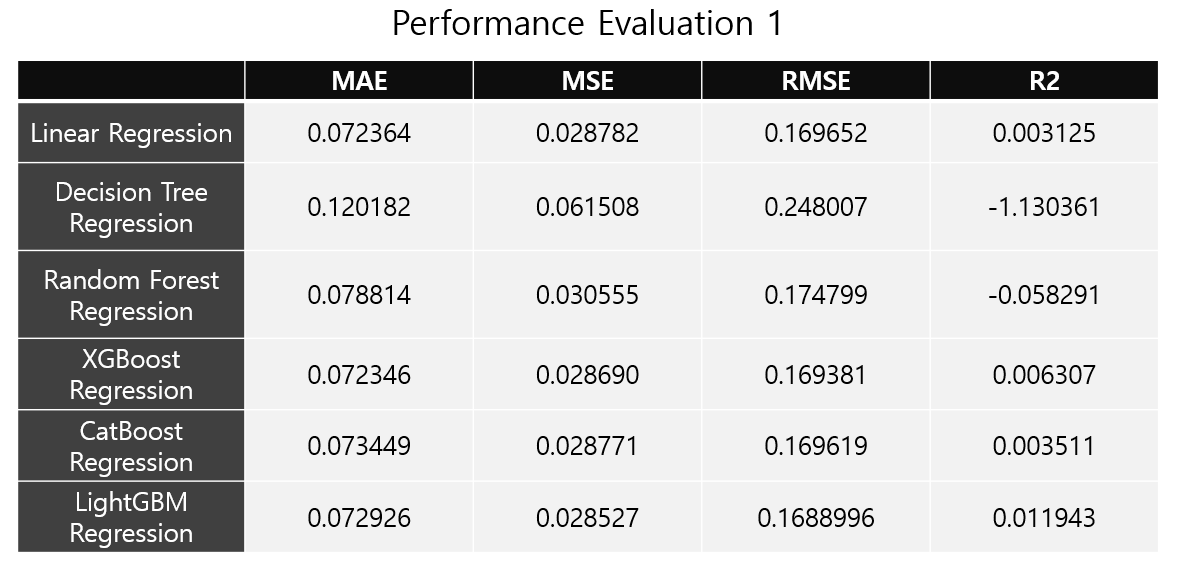

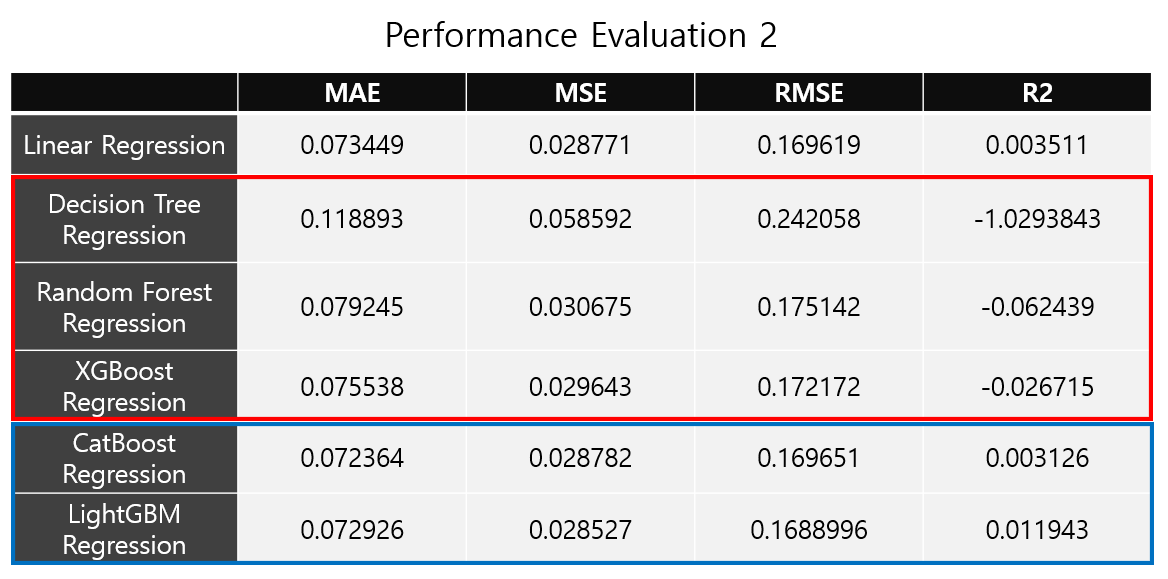

- The three models in the red column were excluded from the model because R2 score was negative.

- The two blue-compartment models passed because they showed good results not only in the MAE, the evaluation we need to obtain, but also in the overall performance evaluation index.

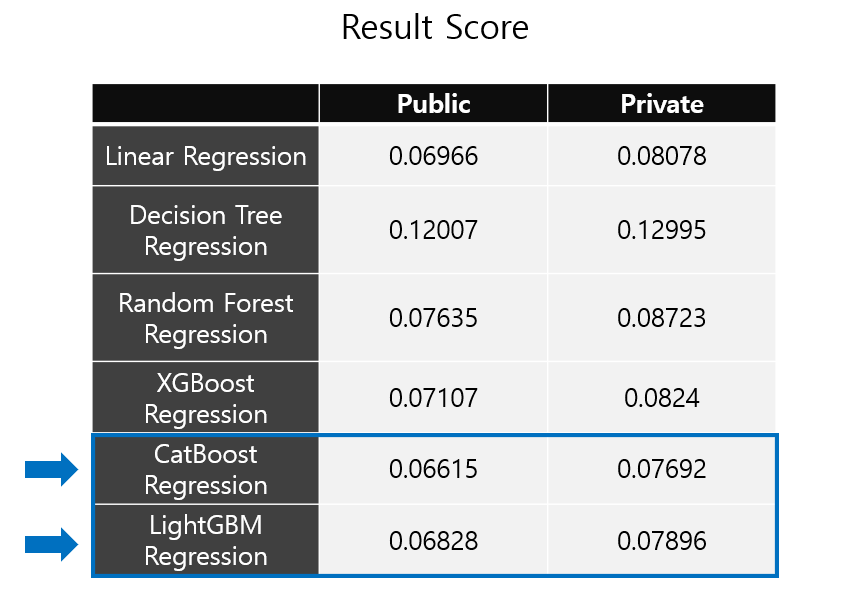

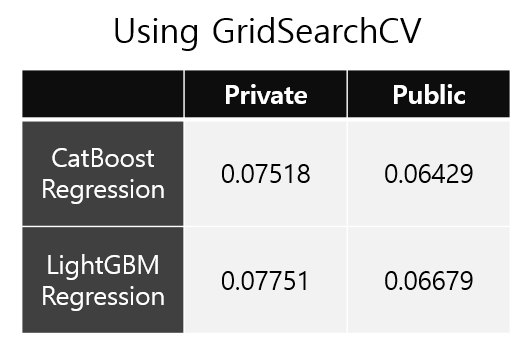

Compare the final score of the model without cross-validation with the final score of the model using cross-validation.

Finally came the most powerful catboost regression.

The value of the hyperparameters of CatBoost Regression measured with the highest performance is
- iterations=630
- learning_rate=0.03
- depth=6
- l2_leaf_reg=3

##  Catboost Modeling (Loading data and Feature Enginnering)
- The add_date_features(df) function was defined to write the year, month, date, and quarter as new variables in the train data.
- Feature Engineering
    1. Variables with missing values of 98% or more were removed.
    2. Since the unique value of the variable was one, the variable that did not affect the result value was removed.
    3. Cat_features for training catboost were specified by specifying the categorical feature.
    4. The missing values of the training features were allocated -999.


In [ ]:
from catboost import CatBoostRegressor
from tqdm import tqdm
import gc
import datetime as dt

print('Loading Properties ...')
properties2016 = pd.read_csv('../input/zillow-prize-1/properties_2016.csv', low_memory = False)
properties2017 = pd.read_csv('../input/zillow-prize-1/properties_2017.csv', low_memory = False)

print('Loading Train ...')
train2016 = pd.read_csv('../input/zillow-prize-1/train_2016_v2.csv', parse_dates=['transactiondate'], low_memory=False)
train2017 = pd.read_csv('../input/zillow-prize-1/train_2017.csv', parse_dates=['transactiondate'], low_memory=False)

def add_date_features(df):
    df["transaction_year"] = df["transactiondate"].dt.year
    df["transaction_month"] = (df["transactiondate"].dt.year - 2016)*12 + df["transactiondate"].dt.month
    df["transaction_day"] = df["transactiondate"].dt.day
    df["transaction_quarter"] = (df["transactiondate"].dt.year - 2016)*4 +df["transactiondate"].dt.quarter
    df.drop(["transactiondate"], inplace=True, axis=1)
    return df

train2016 = add_date_features(train2016)
train2017 = add_date_features(train2017)

print('Loading Sample ...')
sample_submission = pd.read_csv('../input/zillow-prize-1/sample_submission.csv', low_memory = False)

print('Merge Train with Properties ...')
train2016 = pd.merge(train2016, properties2016, how = 'left', on = 'parcelid')
train2017 = pd.merge(train2017, properties2017, how = 'left', on = 'parcelid')

print('Tax Features 2017  ...')
train2017.iloc[:, train2017.columns.str.startswith('tax')] = np.nan

print('Concat Train 2016 & 2017 ...')
train_df = pd.concat([train2016, train2017], axis = 0)
test_df = pd.merge(sample_submission[['ParcelId']], properties2016.rename(columns = {'parcelid': 'ParcelId'}), how = 'left', on = 'ParcelId')

del properties2016, properties2017, train2016, train2017
gc.collect();

print('Remove missing data fields ...')
# Remove variables with a missing value of 98% or more.
missing_perc_thresh = 0.98
exclude_missing = []
num_rows = train_df.shape[0]
for c in train_df.columns:
    num_missing = train_df[c].isnull().sum()
    if num_missing == 0:
        continue
    missing_frac = num_missing / float(num_rows)
    if missing_frac > missing_perc_thresh:
        exclude_missing.append(c)
print("We exclude: %s" % len(exclude_missing))

del num_rows, missing_perc_thresh
gc.collect();


print ("Remove features with one unique value !!")
# The value of the variable is unique, so the variables that do not affect the result value are removed.
exclude_unique = []
for c in train_df.columns:
    num_uniques = len(train_df[c].unique())
    if train_df[c].isnull().sum() != 0:
        num_uniques -= 1
    if num_uniques == 1:
        exclude_unique.append(c)
print("We exclude: %s" % len(exclude_unique))

print ("Define training features !!")
# Remove the variables set above to specify the variables required for training.
exclude_other = ['parcelid', 'logerror','propertyzoningdesc']
train_features = []
for c in train_df.columns:
    if c not in exclude_missing \
       and c not in exclude_other and c not in exclude_unique:
        train_features.append(c)
print("We use these for training: %s" % len(train_features))

print ("Define categorial features !!")
# Specify categorial features with less than 1000 unique values
cat_feature_inds = []
cat_unique_thresh = 1000
for i, c in enumerate(train_features):
    num_uniques = len(train_df[c].unique())
    if num_uniques < cat_unique_thresh \
       and not 'sqft' in c \
       and not 'cnt' in c \
       and not 'nbr' in c \
       and not 'number' in c:
        cat_feature_inds.append(i)
        
print("Cat features are: %s" % [train_features[ind] for ind in cat_feature_inds])

print ("Replacing NaN values by -999 !!")
train_df.fillna(-999, inplace=True)
test_df.fillna(-999, inplace=True)

print ("Training time !!")
X_train = train_df[train_features]
y_train = train_df.logerror
print(X_train.shape, y_train.shape)

test_df['transactiondate'] = pd.Timestamp('2016-12-01') 
test_df = add_date_features(test_df)
X_test = test_df[train_features]
print(X_test.shape)



## cat_features data type
- In catboost, the data type of cat_features should be integer or string.
- In X_train and X_test, we converted the data with the float data type of cat_features into int.

In [ ]:
print("Cat features are: %s" % [train_features[ind] for ind in cat_feature_inds])
for x in cat_feature_inds:
    if X_train.iloc[:,x].dtype =='float64':
        X_train.iloc[:,x] = X_train.iloc[:,x].astype(int)
for x in cat_feature_inds:
    if X_test.iloc[:,x].dtype =='float64':
        X_test.iloc[:,x] = X_test.iloc[:,x].astype(int)
X_train.info()
X_test.info()

## Catboost Training flow
- We predicted y_pred with the average of the five result values by training the Catboost of 5 times.
- Catboost says that the basic parameters are basically well optimized, so we don't have to pay much attention to parameter tuning.
- We considered only these four hyperparameters. (iterations, learning_rate, depth, l2_leaf_reg)
- Loss_function was designated as MAE.
- Use tqdm to display the time and progress of each ensemble.

In [ ]:
num_ensembles = 5
y_pred = 0.0

for i in tqdm(range(num_ensembles)):
    model = CatBoostRegressor(
        iterations=630, learning_rate=0.03,
        depth=6, l2_leaf_reg=3,
        loss_function='MAE',
        eval_metric='MAE',
        random_seed=i,
        verbose=False)
    model.fit(
        X_train, y_train, cat_features= [train_features[ind] for ind in cat_feature_inds])
    y_pred += model.predict(X_test)
y_pred /= num_ensembles

submission = pd.DataFrame({
    'ParcelId': test_df['ParcelId'],
})
test_dates = {
    '201610': pd.Timestamp('2016-09-30'),
    '201611': pd.Timestamp('2016-10-31'),
    '201612': pd.Timestamp('2016-11-30'),
    '201710': pd.Timestamp('2017-09-30'),
    '201711': pd.Timestamp('2017-10-31'),
    '201712': pd.Timestamp('2017-11-30')
}
for label, test_date in test_dates.items():
    print("Predicting for: %s ... " % (label))
    submission[label] = y_pred
    
submission.to_csv('submission.csv', float_format='%.6f',index=False)

## 6. Conclusion and summary of the notebook.

After we dropped features combined lots of missing values and filled values for features using for modeling, we used various models for prediction. Catboost using more than 50% features, and define categorical features, results in the best score in the public score leaderboard from other results of ours. By looking over total scores from the MAE table to the Result Score table, we can find that boost regression models perform better than other regressors. Catboost and LightGBM work well on this data set.
 
So, we have to summarize which combinations of the models and the parameters, which feature engineering work well. 
 
First, Catboost with under 98% missing data features divided categorical features and numerical features for model fitting, is the best score model at this competition criteria. It shows how the categorical features are influential on predict in this data set.

Second, the LGBM model using all feature data is the second-highest score model. Compared to the restoration and use of data with a missing rate of less than 50%, the model using all data scored slightly higher. This suggested that among the variables with a missing value of 50% or more, there is a possibility that variables could have an important influence on the results may be included.

Third, RandomForestRegressor with PCA processed data is the third-highest score model. We used memory reducing for faster one-hot encoding categorical features without ram session down. Its submission file filled null values with 0.01 for the unpredicted values. MAE score of training measured higher than boost models but not that good at submission evaluation than above two models. 
